In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NLP/TranscribeAI/

/content/drive/MyDrive/NLP/TranscribeAI


In [ ]:
!pip install jiwer
!pip install pysrt
!pip install srt
!pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysrt: filename=pysrt-1.1.2-py3-none-any.whl size=13443 sha256=8e3caae0c1389ab4e278b5e9eb2ad0ea41a69d0d9b5f4ffaf7e61c2a50899094
  Stored in directory: /root/.cache/pip/wheels/30/7f/e8/55de9a9b07302d9e7fe47c27910e3bea0c48536153e74bd7e6
Successfully built pysrt
  Preparing metadata (setup.py) ... done
  Created wheel for srt: filename=srt-3.5.3-py3-none-any.whl size=22428 sha256=563e0315a7db024a2c78f8d1325e02b4bbe85eebc34ef90ebaf4aca161a960bb
  Stored in directory: /root/.cache/pip/wheels/d7/31/a1/18e1e7e8bfdafd19e6803d7eb919b563dd11de380e4304e332
Successfully built srt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pysrt
from jiwer import wer, cer
import matplotlib.pyplot as plt
import re
from difflib import SequenceMatcher
import srt
import Levenshtein
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from pysrt import SubRipFile
import pandas as pd
import os

# WER and CER

In [ ]:
def calculate_error_rates(ground_truth_path, whisper_path):
    """
    Calculate Word Error Rate (WER) and Character Error Rate (CER) between two SRT files.

    Parameters:
        ground_truth_path (str): Path to the ground truth SRT file.
        whisper_path (str): Path to the Whisper SRT file.

    Returns:
        dict: A dictionary containing the WER and CER values.
    """
    # Load SRT files
    ground_truth_srt = pysrt.open(ground_truth_path)
    whisper_srt = pysrt.open(whisper_path)

    # Extract text content from the SRT files
    ground_truth_text = " ".join([sub.text for sub in ground_truth_srt])
    whisper_text = " ".join([sub.text for sub in whisper_srt])

    # Calculate WER and CER
    word_error_rate = wer(ground_truth_text, whisper_text)
    char_error_rate = cer(ground_truth_text, whisper_text)

    # Return results
    return {
        "WER": word_error_rate,
        "CER": char_error_rate
    }

In [ ]:
# Example usage
error_rates = calculate_error_rates('Ground_truth_srt/3_min/part1.srt', 'SaT_srt/part1.srt')
print(f"Word Error Rate (WER): {error_rates['WER'] * 100:.2f}%")
print(f"Character Error Rate (CER): {error_rates['CER'] * 100:.2f}%")

Word Error Rate (WER): 10.71%
Character Error Rate (CER): 5.99%


In [ ]:
def process_folders(ground_truth_folder, whisper_folder):
    """
    Process all SRT files in two folders and calculate WER and CER for each corresponding pair.

    Parameters:
        ground_truth_folder (str): Path to the folder containing the ground truth SRT files.
        whisper_folder (str): Path to the folder containing the Whisper SRT files.

    Returns:
        dict: A dictionary where keys are SRT filenames, and values are dictionaries with WER and CER.
    """
    error_rates = {}
    total_wer = 0
    total_cer = 0
    num_files = 0

    # Get all the SRT filenames from both folders
    ground_truth_files = sorted([f for f in os.listdir(ground_truth_folder) if f.endswith('.srt')])
    whisper_files = sorted([f for f in os.listdir(whisper_folder) if f.endswith('.srt')])

    # Ensure both folders have the same number of files
    if len(ground_truth_files) != len(whisper_files):
        raise ValueError("The number of SRT files in the two folders do not match.")

    # Process each pair of corresponding SRT files
    for gt_file, whisper_file in zip(ground_truth_files, whisper_files):
        ground_truth_path = os.path.join(ground_truth_folder, gt_file)
        whisper_path = os.path.join(whisper_folder, whisper_file)

        # Calculate error rates for the current pair
        error_rate = calculate_error_rates(ground_truth_path, whisper_path)
        error_rates[gt_file] = error_rate

        # Accumulate the WER and CER values for averaging
        total_wer += error_rate["WER"]
        total_cer += error_rate["CER"]
        num_files += 1

    # Calculate averages
    average_wer = total_wer / num_files if num_files else 0
    average_cer = total_cer / num_files if num_files else 0

    return error_rates, average_wer, average_cer

In [ ]:
# Example usage
ground_truth_folder = 'Ground_truth_srt/3_min'
whisper_folder = 'SaT_srt'

# Calculate error rates for all SRT files in both folders
all_error_rates, average_wer, average_cer = process_folders(ground_truth_folder, whisper_folder)

# Create a pandas DataFrame to display the results
df = pd.DataFrame.from_dict(all_error_rates, orient='index')

# Add averages as a new row
df.loc["Average"] = [average_wer, average_cer]

# Display the table
df

# Optionally, save the results to a CSV file
# df.to_csv("error_rates_summary.csv")

,WER,CER
analysis1.srt,0.078652,0.049256
analysis2.srt,0.124752,0.089658
analysis3.srt,0.167347,0.049602
part1.srt,0.107071,0.059895
part10.srt,0.109620,0.055346
part11.srt,0.067442,0.040816
part12.srt,0.116162,0.073452
part13.srt,0.129344,0.103612
part2.srt,0.079320,0.042634
part3.srt,0.061224,0.026500


In [ ]:
# Optionally, save the results to a CSV file
df.to_csv("error_rates_summary_SAT.csv")

#Check word counts per segment

In [ ]:
def parse_srt(srt_content):
    """
    Parses the SRT content and returns a list of tuples containing the start and end times
    and the corresponding subtitle text.
    """
    entries = re.split(r'\n\s*\n', srt_content.strip())  # Split entries by empty lines
    parsed_entries = []

    for entry in entries:
        parts = entry.split('\n')
        time_range = parts[1]  # The time interval
        subtitle_text = ' '.join(parts[2:])  # The subtitle text
        start_time, end_time = time_range.split(' --> ')  # Split time range
        parsed_entries.append((start_time, end_time, subtitle_text))

    return parsed_entries

def count_words_per_segment(srt_data):
    """
    Counts the number of words in each subtitle segment from parsed SRT data.
    Returns a list of word counts for each segment.
    """
    word_counts = []

    for entry in srt_data:
        subtitle_text = entry[2]  # The subtitle text
        word_count = len(subtitle_text.split())  # Split by spaces and count words
        word_counts.append(word_count)

    return word_counts

In [ ]:
# Load ground truth and Whisper SRT files
gt_srt ='Ground_truth_srt/3_min/part1.srt'
whisper_srt = 'Segment_fn_srt/captions_part1.srt'

In [ ]:
# Example usage:
# Load the content of your GT SRT and Whisper SRT files (assuming they are read as strings)
with open(gt_srt, 'r') as file:
    gt_srt_content = file.read()

with open(whisper_srt, 'r') as file:
    whisper_srt_content = file.read()

# Parse both SRTs
gt_srt = parse_srt(gt_srt_content)
whisper_srt = parse_srt(whisper_srt_content)

# Count the number of words in each segment for both GT and Whisper SRTs
gt_word_counts = count_words_per_segment(gt_srt)
whisper_word_counts = count_words_per_segment(whisper_srt)

# Print the results
print("GT SRT Word Counts per Segment: ", gt_word_counts)
print("Segment fn SRT Word Counts per Segment:", whisper_word_counts)

GT SRT Word Counts per Segment:  [1, 1, 6, 4, 6, 8, 7, 4, 7, 11, 4, 3, 12, 8, 11, 8, 7, 2, 7, 5, 9, 10, 11, 8, 4, 4, 10, 11, 11, 2, 4, 10, 4, 10, 5, 10, 12, 8, 11, 7, 10, 12, 11, 8, 7, 10, 2, 9, 2, 7, 7, 1, 8, 10, 6, 6, 5, 12, 3, 11, 5, 9, 4, 10, 5, 4, 4, 4, 9, 11]
Segment fn SRT Word Counts per Segment: [1, 1, 8, 8, 8, 7, 4, 8, 2, 8, 4, 8, 8, 8, 1, 8, 3, 8, 8, 1, 1, 1, 7, 8, 8, 8, 1, 1, 8, 3, 8, 1, 8, 8, 2, 8, 3, 8, 3, 2, 4, 8, 2, 8, 8, 8, 7, 8, 5, 8, 8, 3, 7, 8, 2, 8, 8, 1, 8, 7, 7, 3, 8, 1, 8, 1, 2, 7, 8, 8, 8, 2, 7, 2, 6, 5, 8, 8, 2, 8, 1, 8, 1, 8, 2, 3, 7, 2, 3, 4, 2, 2, 1, 3, 8, 1, 1, 1, 8, 6]


In [ ]:
len(whisper_word_counts)

100

# Visualize the word counts segment-wise - part1.srt

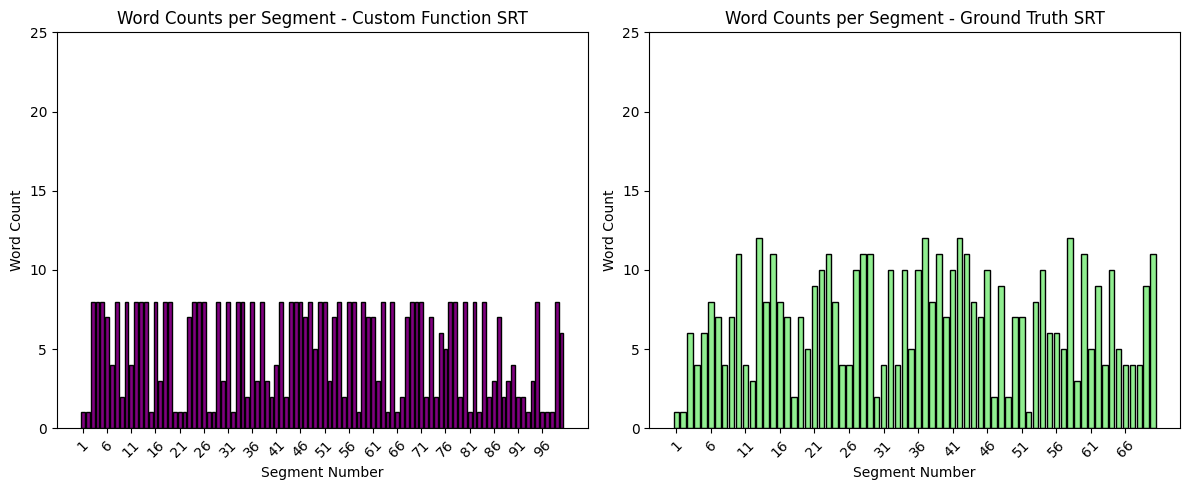

In [ ]:
# Generate segment numbers (x-axis)
whisper_segments = list(range(1, len(whisper_word_counts) + 1))
gt_segments = list(range(1, len(gt_word_counts) + 1))

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Whisper Word Counts Bar Chart
axes[0].bar(whisper_segments, whisper_word_counts, color='purple', edgecolor='black')
axes[0].set_xlabel('Segment Number')
axes[0].set_ylabel('Word Count')
axes[0].set_title('Word Counts per Segment - Custom Function SRT')
axes[0].set_ylim(0,25)
axes[0].set_xticks(range(1, len(whisper_word_counts) + 1, 5))  # Show every 5th segment on x-axis
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better visibility

# Ground Truth Word Counts Bar Chart
axes[1].bar(gt_segments, gt_word_counts, color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Segment Number')
axes[1].set_ylabel('Word Count')
axes[1].set_title('Word Counts per Segment - Ground Truth SRT')
axes[1].set_xticks(range(1, len(gt_word_counts) + 1, 5))  # Show every 5th segment on x-axis
axes[1].set_ylim(0,25)
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better visibility

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Compare Segments: using text similarity metrics
1. levenshtein
2. cosine similarity
3. sequence similarity - SequenceMatcher

In [ ]:
def text_similarity(text1, text2, method="levenshtein"):
    """Calculate the similarity between two texts using the specified method."""
    if method == "Levenshtein":
        return Levenshtein.ratio(text1, text2)

    elif method == "Cosine":
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform([text1, text2])
        return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

    elif method == "Sequence-Match":
        return SequenceMatcher(None, text1, text2).ratio()

    else:
        raise ValueError("Invalid similarity method. Choose from 'levenshtein', 'cosine', or 'sequence'.")

In [ ]:
def compare_srt_files(gt_file, whisper_file, methods, similarity_threshold=0.3):
    """Compare two SRT files and calculate average similarity for each method."""
    with open(gt_file, 'r') as f:
        gt_subtitles = list(srt.parse(f.read()))

    with open(whisper_file, 'r') as f:
        whisper_subtitles = list(srt.parse(f.read()))

    similarities = {method: [] for method in methods}

    for gt, whisper in zip(gt_subtitles, whisper_subtitles):
        for method in methods:
            score = text_similarity(gt.content, whisper.content, method=method)
            similarities[method].append(score)

    # Calculate average similarity for each method
    avg_similarities = {method: sum(scores) / len(scores) for method, scores in similarities.items()}
    return avg_similarities

def get_files_from_directory(directory, file_extension=".srt"):
    """Retrieve all files from a directory."""
    files = {}
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith(file_extension):
                base_name = os.path.basename(filename)
                files[base_name] = os.path.join(root, filename)
    return files

def pair_files(dir1, dir2, file_extension=".srt"):
    """Pair files from two directories by base name."""
    files1 = get_files_from_directory(dir1, file_extension)
    files2 = get_files_from_directory(dir2, file_extension)

    return [(files1[name], files2[name]) for name in files1 if name in files2]

def pair_files_segment(dir1, dir2, file_extension=".srt"):
    """Pair files from two directories if a file name in dir1 is a substring of a file name in dir2."""
    files1 = get_files_from_directory(dir1, file_extension)
    files2 = get_files_from_directory(dir2, file_extension)
    #print(files2)
    pairs = []

    for file1 in files1:
        base_name1 = os.path.splitext(file1)[0]+".srt"  # Get the base name without extension
        for file2 in files2:
          if base_name1 in file2:  # Check if base_name1 is a substring of file2
              pairs.append(("Ground_truth_srt/3_min/"+file1, "Segment_fn_srt/"+file2))

    return pairs

In [ ]:
# Main comparison
def get_table(gt_directory, whisper_directory, methods=["Levenshtein", "Cosine", "Sequence-Match"]):
    # Pair files
    paired_files = pair_files(gt_directory, whisper_directory)

    # Prepare data for the table
    results = []
    for gt_file, whisper_file in paired_files:
        avg_similarities = compare_srt_files(gt_file, whisper_file, methods)
        results.append({
            #"GT File": os.path.basename(gt_file),
            #"Whisper File": os.path.basename(whisper_file),
            "File":os.path.basename(gt_file),
            **avg_similarities
        })

    # Create DataFrame
    df = pd.DataFrame(results)
    return df

In [ ]:
from tabulate import tabulate
import pandas as pd

# Function to prepare tables for display
def create_formatted_table(df, table_title):
    """
    Format the DataFrame as a table for display in a report.
    """
    print(f"\n{table_title}\n")
    print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))

In [ ]:
# Example usage
gt_directory = "Ground_truth_srt/3_min"
comp_directory = "Gemini_async/srts"

df = get_table(gt_directory, comp_directory)

In [ ]:
create_formatted_table(df, "Table 1: Results for Gemini")


Table 1: Results for Gemini

+---------------+---------------+-----------+------------------+
| File          |   Levenshtein |    Cosine |   Sequence-Match |
+===============+===============+===========+==================+
| part1.srt     |      0.3992   | 0.151927  |         0.340963 |
+---------------+---------------+-----------+------------------+
| part2.srt     |      0.384373 | 0.0712293 |         0.328936 |
+---------------+---------------+-----------+------------------+
| part3.srt     |      0.371963 | 0.0520343 |         0.299103 |
+---------------+---------------+-----------+------------------+
| part4.srt     |      0.433561 | 0.218485  |         0.392456 |
+---------------+---------------+-----------+------------------+
| part5.srt     |      0.340437 | 0.0290804 |         0.275462 |
+---------------+---------------+-----------+------------------+
| part6.srt     |      0.399257 | 0.118872  |         0.333352 |
+---------------+---------------+-----------+---------------

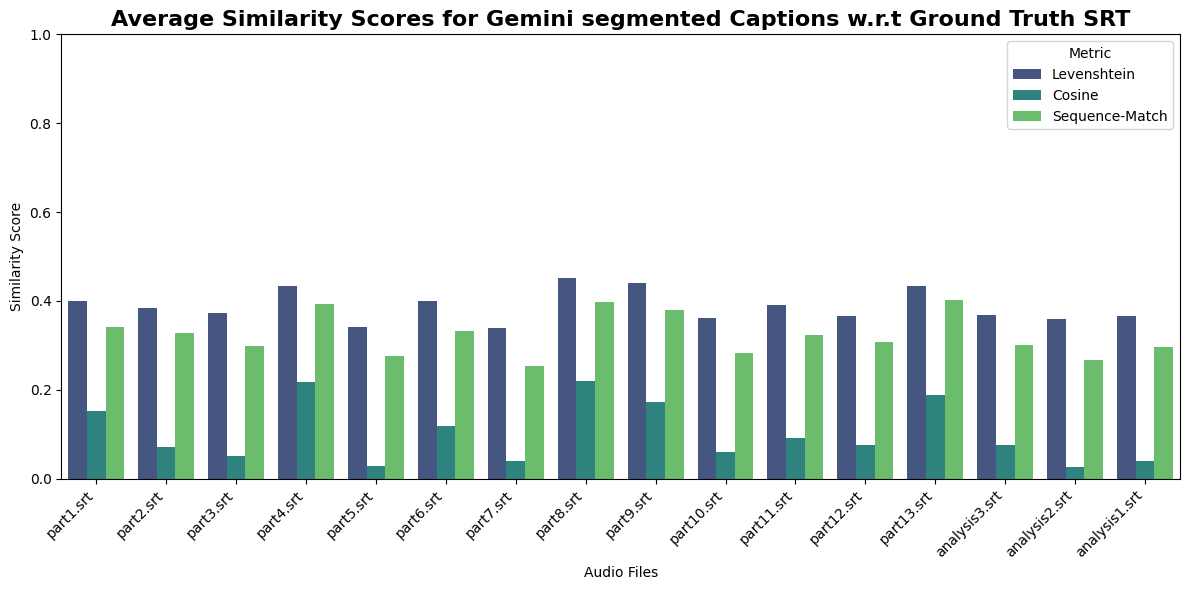

Plot saved as segment_fn_similarity_scores.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_scores(df, title, output_file):
    """
    Plot similarity scores as a bar chart for each file pair.
    """
    # Melt the DataFrame to make it suitable for Seaborn
    melted_df = df.melt(
        id_vars=["File"],
        value_vars=["Levenshtein", "Cosine", "Sequence-Match"],
        var_name="Similarity Metric",
        value_name="Score"
    )

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x="File",
        y="Score",
        hue="Similarity Metric",
        data=melted_df,
        palette="viridis"
    )
    plt.title(title, fontsize=16, fontweight="bold")
    plt.ylabel("Similarity Score")
    plt.xlabel("Audio Files")
    plt.ylim(0, 1)  # Similarity scores are between 0 and 1
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Metric", fontsize=10)
    plt.tight_layout()

    # Save the plot
    plt.savefig(output_file, dpi=300)
    plt.show()
    print(f"Plot saved as {output_file}")

# Example usage
plot_similarity_scores(
    df,
    "Average Similarity Scores for Gemini segmented Captions w.r.t Ground Truth SRT",
    "segment_fn_similarity_scores.png"
)


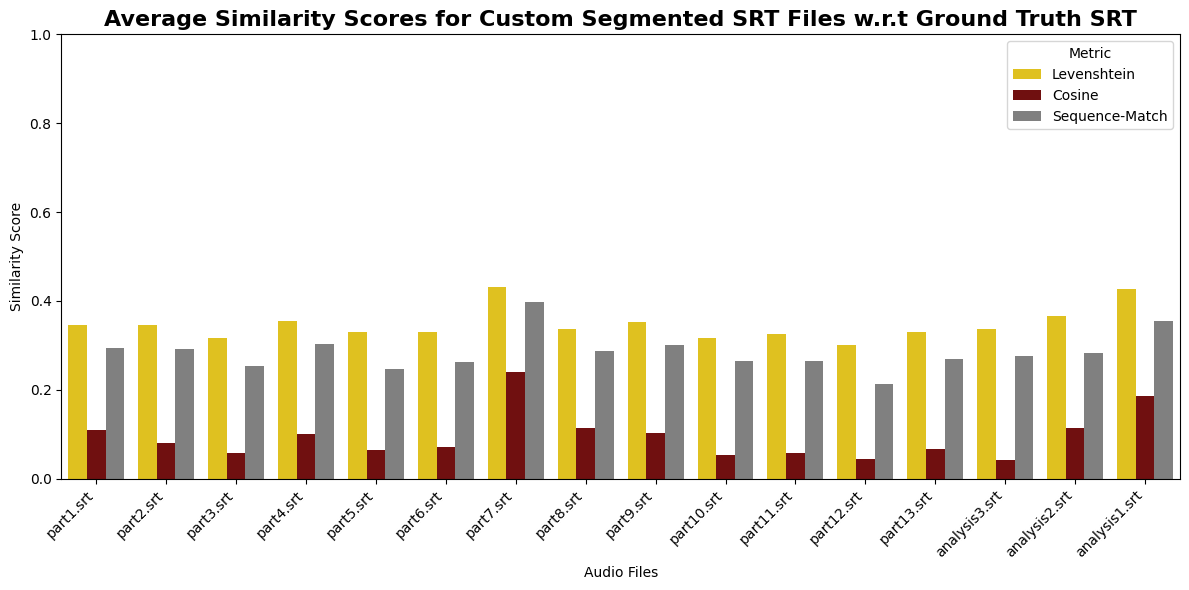

Plot saved as segment_fn_similarity_scores.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_scores(df, title, output_file):
    """
    Plot similarity scores as a bar chart for each file pair with custom colors.
    """
    # Melt the DataFrame to make it suitable for Seaborn
    melted_df = df.melt(
        id_vars=["File"],
        value_vars=["Levenshtein", "Cosine", "Sequence-Match"],
        var_name="Similarity Metric",
        value_name="Score"
    )

    # Custom color palette
    custom_palette = ["gold", "maroon", "grey"]

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x="File",
        y="Score",
        hue="Similarity Metric",
        data=melted_df,
        palette=custom_palette
    )
    plt.title(title, fontsize=16, fontweight="bold")
    plt.ylabel("Similarity Score")
    plt.xlabel("Audio Files")
    plt.ylim(0, 1)  # Similarity scores are between 0 and 1
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Metric", fontsize=10)
    plt.tight_layout()

    # Save the plot
    plt.savefig(output_file, dpi=300)
    plt.show()
    print(f"Plot saved as {output_file}")

# Example usage
plot_similarity_scores(
    df,
    "Average Similarity Scores for Custom Segmented SRT Files w.r.t Ground Truth SRT",
    "segment_fn_similarity_scores.png"
)


In [ ]:
# get averages
import pandas as pd

def compute_average_scores(df):
    """
    Compute average similarity scores across 'levenshtein', 'cosine', and 'sequence'.
    Display the results as a table.
    """
    # Calculate average scores for each column
    avg_scores = df[['Levenshtein', 'Cosine', 'Sequence-Match']].mean().reset_index()
    avg_scores.columns = ['Metric', 'Average Score']

    # Display the table
    print(avg_scores)

    return avg_scores

# Example usage
avg_scores = compute_average_scores(df)

# Display as a simple table
from tabulate import tabulate
print(tabulate(avg_scores, headers='keys', tablefmt='fancy_grid'))


           Metric  Average Score
0     Levenshtein       0.387724
1          Cosine       0.101963
2  Sequence-Match       0.323818
╒════╤════════════════╤═════════════════╕
│    │ Metric         │   Average Score │
╞════╪════════════════╪═════════════════╡
│  0 │ Levenshtein    │        0.387724 │
├────┼────────────────┼─────────────────┤
│  1 │ Cosine         │        0.101963 │
├────┼────────────────┼─────────────────┤
│  2 │ Sequence-Match │        0.323818 │
╘════╧════════════════╧═════════════════╛


In [ ]:
def combine_avg_scores(model_scores):
    """
    Combine average scores from multiple models into a single table.
    """
    # Create a DataFrame from the dictionary of model scores
    combined_df = pd.DataFrame(model_scores)

    # Display the combined table
    print(tabulate(combined_df, headers='keys', tablefmt='fancy_grid'))

    return combined_df

# Example input: Average scores from 4 models
model_scores = {
    "Model": ["Whisper-Timestamped", "Gemini-async", "SaT", "Custom_function"],
    "Levenshtein": [0.32098, 0.38772,0.31931 , 0.346860],
    "Cosine": [0.06009, 0.10196, 0.06716, 0.09407],
    "Sequence-Match": [0.23950, 0.32382,0.24393 , 0.28536]
}

# Combine and display
combined_avg_scores = combine_avg_scores(model_scores)

╒════╤═════════════════════╤═══════════════╤══════════╤══════════════════╕
│    │ Model               │   Levenshtein │   Cosine │   Sequence-Match │
╞════╪═════════════════════╪═══════════════╪══════════╪══════════════════╡
│  0 │ Whisper-Timestamped │       0.32098 │  0.06009 │          0.2395  │
├────┼─────────────────────┼───────────────┼──────────┼──────────────────┤
│  1 │ Gemini-async        │       0.38772 │  0.10196 │          0.32382 │
├────┼─────────────────────┼───────────────┼──────────┼──────────────────┤
│  2 │ SaT                 │       0.31931 │  0.06716 │          0.24393 │
├────┼─────────────────────┼───────────────┼──────────┼──────────────────┤
│  3 │ Custom_function     │       0.34686 │  0.09407 │          0.28536 │
╘════╧═════════════════════╧═══════════════╧══════════╧══════════════════╛


In [ ]:
import pandas as pd

def compute_average_scores(df):
    """
    Compute average similarity scores across 'levenshtein', 'cosine', and 'sequence'.
    Display the results as a table.
    """
    # Calculate average scores for each column
    avg_scores = df[['Levenshtein', 'Cosine', 'Sequence-Match']].mean().reset_index()
    avg_scores.columns = ['Metric', 'Average Score']

    # Display the table
    print(avg_scores)

    return avg_scores

# Example usage
avg_scores = compute_average_scores(df)

# Display as a simple table
from tabulate import tabulate
print(tabulate(avg_scores, headers='keys', tablefmt='fancy_grid'))


           Metric  Average Score
0     Levenshtein       0.319306
1          Cosine       0.067164
2  Sequence-Match       0.243934
╒════╤════════════════╤═════════════════╕
│    │ Metric         │   Average Score │
╞════╪════════════════╪═════════════════╡
│  0 │ Levenshtein    │       0.319306  │
├────┼────────────────┼─────────────────┤
│  1 │ Cosine         │       0.0671642 │
├────┼────────────────┼─────────────────┤
│  2 │ Sequence-Match │       0.243934  │
╘════╧════════════════╧═════════════════╛


# Get average time differences

In [ ]:

from datetime import datetime, timedelta
import re

def parse_srt(file_path):
    """Parse the .srt file and return a list of (timestamp, text)."""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    segments = re.split(r'\n\s*\n', content.strip())
    timestamps = []

    for segment in segments:
        lines = segment.splitlines()
        if len(lines) >= 3:
            timestamp_line = lines[1]
            text_lines = lines[2:]
            timestamps.append((timestamp_line, " ".join(text_lines)))

    return timestamps

def get_first_word_timestamp(timestamp):
    """Get the timestamp of the first word based on the segment's start time."""
    # Parse the start time from the timestamp line (e.g., "00:00:01,600 --> 00:00:03,800")
    start_time_str = timestamp.split('-->')[0].strip()
    start_time = datetime.strptime(start_time_str, '%H:%M:%S,%f')
    return start_time

def compare_timestamps(srt1_path, srt2_path):
    """Compare timestamps of the first word in each segment of two .srt files."""
    srt1_segments = parse_srt(srt1_path)
    srt2_segments = parse_srt(srt2_path)
    length = min(len(srt1_segments),len(srt2_segments))

    time_differences = []

    for (timestamp1, _), (timestamp2, _) in zip(srt1_segments[:length], srt2_segments[:length]):
        time1 = get_first_word_timestamp(timestamp1)
        time2 = get_first_word_timestamp(timestamp2)
        time_diff = abs((time1 - time2).total_seconds())
        time_differences.append(time_diff)

    return time_differences

In [ ]:
# Example usage
# Load ground truth and Whisper SRT files
gt_srt ='Ground_truth_srt/3_min/part1.srt'
whisper_srt = 'Gemini_srt/part1.srt' ##'Segment_fn_srt/captions_part1.srt'


time_differences = compare_timestamps(gt_srt, whisper_srt)

# Display list of differences
print("Time Differences (in seconds):")
print(time_differences)

Time Differences (in seconds):
[0.0, 4.76, 8.559, 6.493, 12.72, 16.239, 19.42, 24.557, 27.343, 26.829, 28.29, 28.683, 31.203, 35.669, 34.064, 31.237, 33.284, 35.091, 38.703, 42.803, 46.223, 48.603, 47.589, 52.536, 49.583, 51.764, 50.589, 51.617, 53.103, 53.257, 54.916, 56.289, 56.15, 62.236, 60.823, 61.549, 61.649, 60.723, 58.617, 60.269, 60.029, 57.397, 54.59, 51.376, 47.323, 45.969, 42.09, 43.57, 49.356]


In [ ]:
len(time_differences)

49

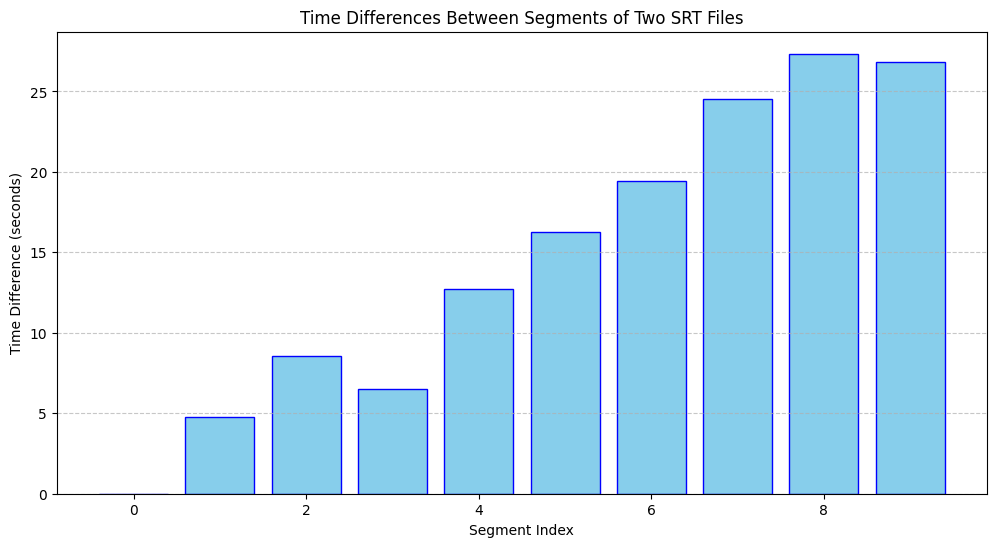

In [ ]:
def plot_time_differences(differences):
    """Plot the list of time differences as a bar plot."""
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(differences[:10])), differences[:10], color='skyblue', edgecolor='blue')
    plt.xlabel('Segment Index')
    plt.ylabel('Time Difference (seconds)')
    plt.title('Time Differences Between Segments of Two SRT Files')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_time_differences(time_differences)